In [171]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

from functools import partial
# from numpy.fft import fft, fftshift, ifftshift
from scipy.fftpack import fft, ifft
from scipy.integrate import quad
from scipy.interpolate import interp1d

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Fourier Inversion

It can be shown that the characteristic function of a random variable $X$ is the Fourier transform of the density function of $X$:

$$
\begin{aligned}
F_X(x) = \frac{1}{2} - \frac{1}{2\pi} \int_\mathbb{R} e^{-iux}\psi_X(u)\frac{1}{iu}du
\end{aligned}
$$

Density function can be obtained by taking the derivative of the CDF via the **Gil Pelaez formula**:

$$
\begin{aligned}
f_X(x) = \frac{1}{\pi} \int_0^\infty \text{Re}(e^{-iux}\psi_X(u))du
\end{aligned}
$$




---

## Transormation of the common distributions

In [172]:
def cf_normal(u, mu, sig):
    return np.exp(1j * u * mu - 0.5 * u**2 * sig**2)

def cf_gamma(u, a, b):
    return (1 - b * u * 1j) ** (-a)

def cf_poisson(u, lam):
    return np.exp(lam * (np.exp(1j * u) - 1))

In [173]:
def Gil_Pelaez_pdf(x, cf, right_lim):
    '''Gil Pelaez formula for the density
    Parameters
    ----------
    x : array_like
        Points at which to evaluate the density.
    cf : callable
        Characteristic function of the distribution.
    right_lim : float
        Right limit of the integral.

    Returns
    -------
    pdf : array_like
        Probability density function evaluated at `x`.
    '''
    integrand = lambda u: np.real(np.exp(-u * x * 1j) * cf(u))
    return 1 / np.pi * quad(integrand, 1e-15, right_lim)[0]

# quad(integrand, 1e-15, np.inf)[0] means: integrate the function `integrand` from 1e-15 to infinity. The [0] at the end means that we only want the first element of the output, which is the value of the integral. The second element is the estimated error of the integral.

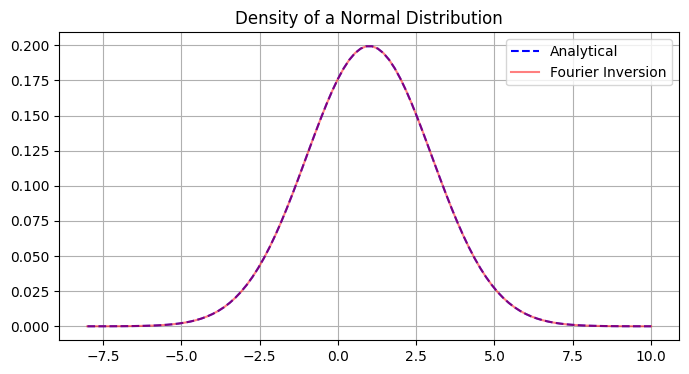

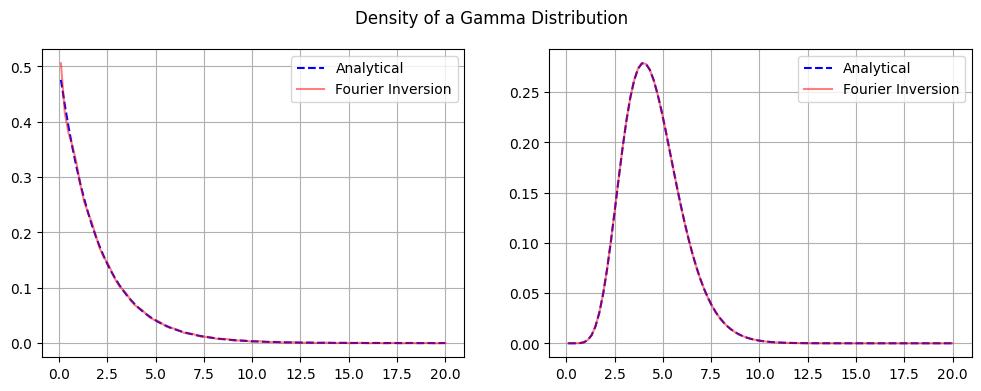

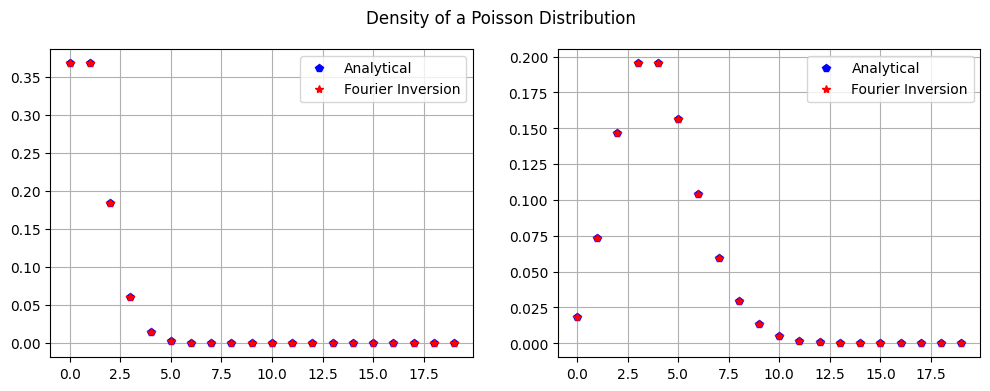

In [174]:
# Normal --------------------------------------------------------------------------------------------
x = np.linspace(-8, 10, 100)
y = ss.norm.pdf(x, loc = 1, scale = 2)
cf_normal_12 = partial(cf_normal, mu = 1, sig = 2)

y1_numerical = [Gil_Pelaez_pdf(x_i, cf_normal_12, 100) for x_i in x]

plt.figure(figsize=(8, 4))
plt.title("Density of a Normal Distribution")
plt.plot(x, y, color = "blue", ls = "--", label = "Analytical")
plt.plot(x, y1_numerical, color = "red", alpha = 0.5, label = "Fourier Inversion")
plt.legend()
plt.grid()
plt.show()

# Gamma ---------------------------------------------------------------------------------------------
lim1 = 24 # Cannot integrate further than 24 because Gamma(1, 2)'s characteristic is oscillating significantly
cf_gamma_1 = partial(cf_gamma, a = 1, b = 2)

lim2 = np.inf
cf_gamma_2 = partial(cf_gamma, a = 9, b = 0.5)

x = np.linspace(0.1, 20, 100)
y1 = ss.gamma.pdf(x, a = 1, scale = 2)
y2 = ss.gamma.pdf(x, a = 9, scale = 0.5)

y1_numerical = [Gil_Pelaez_pdf(x_i, cf_gamma_1, lim1) for x_i in x]
y2_numerical = [Gil_Pelaez_pdf(x_i, cf_gamma_2, lim2) for x_i in x]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Density of a Gamma Distribution")

ax[0].plot(x, y1, color = "blue", ls = "--", label = "Analytical")
ax[0].plot(x, y1_numerical, color = "red", alpha = 0.5, label = "Fourier Inversion")
ax[0].legend()
ax[0].grid()

ax[1].plot(x, y2, color = "blue", ls = "--", label = "Analytical")
ax[1].plot(x, y2_numerical, color = "red", alpha = 0.5, label = "Fourier Inversion")
ax[1].legend()
ax[1].grid()

plt.show()

# Poisson -------------------------------------------------------------------------------------------
x = np.arange(0, 20)
cf_poisson_1 = partial(cf_poisson, lam = 1)
cf_poisson_4 = partial(cf_poisson, lam = 4)

y1 = ss.poisson.pmf(x, mu = 1)
y4 = ss.poisson.pmf(x, mu = 4)

y1_numerical = [Gil_Pelaez_pdf(x_i, cf_poisson_1, np.pi) for x_i in x]
y2_numerical = [Gil_Pelaez_pdf(x_i, cf_poisson_4, np.pi) for x_i in x]

# Notice we only integrate up to pi because the characteristic function of the Poisson distribution is oscillating periodically with period 2pi. Therefore, integrating from 0 to 2pi will give us the same result as integrating from 0 to pi. Further integration will result in infinity.

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Density of a Poisson Distribution")

ax[0].plot(x, y1, color = "blue", marker = "p", ls = "None", label = "Analytical")
ax[0].plot(x, y1_numerical, color = "red", marker = "*", ls = "None", label = "Fourier Inversion")
ax[0].legend()
ax[0].grid()

ax[1].plot(x, y4, color = "blue", marker = "p", ls = "None", label = "Analytical")
ax[1].plot(x, y2_numerical, color = "red", marker = "*", ls = "None", label = "Fourier Inversion")
ax[1].legend()
ax[1].grid()

plt.show()

## Option pricing

Let us apply the pricing formula introduced above using the following processes:
- Geometric Brownian motion
- Merton process
- Variance Gamma process

### Pricing formula by Fourier inversion

In the notebook **1.1** we found that the pricing formula for a call option with stike K and maturity T is: 

$$  C(S_t,K,T) = S_t \tilde{\mathbb{Q}} ( S_T > K ) - e^{-r(T-t)} K \, \mathbb{Q}( S_T >K ) $$

where $\tilde{\mathbb{Q}}$ is the probability under the stock numeraire and $\mathbb{Q}$ is the probability under the money market numeraire.

#### This formula is model independent! 

When the stock follows a geometric Brownian motion, this formula corresponds to the Black-Scholes formula.

Now let us express $\tilde{\mathbb{Q}}$ and $\mathbb{Q}$ in terms of the characteristic function using the Gil Pelaez formula.    
Let us call $k = \log \frac{K}{S_t}$ and $S_T = S_t e^{X_T}$
- For $\mathbb{Q}$ we can write: 

\begin{align*}
\mathbb{Q}(S_T >K) &= 1 - \mathbb{Q}(S_T <K) = 1 - \mathbb{Q}(X_T < k) \\
                   &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u)}{iu} \biggr] du
\end{align*}

- In the same way, for $\tilde{\mathbb{Q}}$, we can write: 

\begin{align*}
\tilde{\mathbb{Q}}(S_T >K) &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \tilde{\phi}_X(u)}{iu} \biggr] du \\
                          &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u-i)}{iu \, \phi_X(-i)} \biggr] du  
\end{align*}

where

\begin{align*}
 \tilde{\phi}_X(u) &= \mathbb{E}^{\tilde{\mathbb{Q}}} \bigl[ e^{iuX_T} \bigr] = \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{d\tilde{\mathbb{Q}}}{d \mathbb{Q}} e^{iuX_T} \biggr] \\  
                   &= \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{S_t e^{X_T}}{S_t \mathbb{E}^\mathbb{Q}[e^{X_T}]} e^{iuX_T} \biggr] \\
                   &= \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{e^{(iu+1)X_T}}{\phi_X(-i)} \biggr] \\
                   &= \frac{\phi_X(u-i)}{\phi_X(-i)}
\end{align*}


In [175]:
def Q1(k, cf, right_lim):
    integrand = lambda u: np.real(np.exp(-u * k * 1j) * cf(u - 1j) / ((u * 1j) * cf(-1j)))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit = 1000)[0]

def Q2(k, cf, right_lim):
    integrand = lambda u: np.real(np.exp(-u * k * 1j) * cf(u) / (u * 1j))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit = 1000)[0]

# Here limit = 1000 means that we want to use 1000 intervals to approximate the integral. The default value is 50.

In [176]:
# PARAMETERS ----------------------------------------------------------------------------------------
S0 = 100
K = 100
T = 1
k = np.log(K / S0) # Log-moneyness

In [177]:
# GBM -----------------------------------------------------------------------------------------------
r = 0.1
sigma = 0.2

cf_GBM = partial(cf_normal, mu = (r - 0.5 * sigma**2) * T, sig = sigma * np.sqrt(T))
call_inversion = S0 * Q1(k, cf_GBM, np.inf) - K * np.exp(-r * T) * Q2(k, cf_GBM, np.inf)

# Black-Scholes -------------------------------------------------------------------------------------
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

call_BS = S0 * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)

print("Call price of GBM = {:.4f}".format(call_inversion))
print("Call price of BS = {:.4f}".format(call_BS))

Call price of GBM = 13.2697
Call price of BS = 13.2697


In [ ]:
# Merton -------------------------------------------------------------------------------------------
